# Book Recommendation Systems
### 02807 Computational tools for Data Science  
#### By Lukas A. G. Mittun (s204174), Styliani Kalyva (s222752), Marina Epitropaki (s222727) & Àiax Faura Vilalta (s222703)
-----------------

In [1]:
# imports
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os
import sklearn
import string as str
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from ast import literal_eval

# Data Loading and Cleaning
Our initial dataframe is "Preprocessed_data.csv". It contained plenty of extra data we wouldn’t use, so we cleaned it by removing rows with zero votes because they would cause non equal handling. Then we removed columns that contained images and all rows that contained at least a null response and narrowed it down. In each method, either we created new data frames from it, according to our needs or we cleaned the data further.

In [2]:
# Loading csv with preprocessed data
df = pd.read_csv('Preprocessed_data.csv')

# Cleaning the data
# Removing zero ratings
df = df[df['rating'] != 0]

In [3]:
# Removing image_url columns because we will not use it.
df = df.drop(['img_s'], axis=1)
df = df.drop(['img_m'], axis=1)
df = df.drop(['img_l'], axis=1)
df = df.dropna()
df = df.reset_index(drop=True)

In [4]:
df.head(5)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,Summary,Language,Category,city,state,country
0,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
1,5,67544,"toronto, ontario, canada",30.0000,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],toronto,ontario,canada
2,9,123629,"kingston, ontario, canada",34.7439,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],kingston,ontario,canada
3,11,200273,"comber, ontario, canada",34.7439,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],comber,ontario,canada
4,12,210926,"guelph, ontario, canada",34.7439,0002005018,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],guelph,ontario,canada


In [5]:
df.to_csv('Preprocessed_data_cleaned.csv', index=False)

From now on we can work with df or load from the beggining 
the Preprocessed_data_cleaned.csv file

-------------------------------------------------------------------
# Demographic Filtering
We use this method to find the most popular books among all users and then by country.

## Internationally: We will find the top rated books globally

In [6]:
# Loading csv with book rating data
df_book_rating = pd.read_csv('BX-Book-Ratings.csv', sep=';',encoding= 'unicode_escape', engine='python')

#turns column to int
df_book_rating['Book-Rating']=[int(df_book_rating['Book-Rating'][rating].replace("'", '')) for rating in range(len(df_book_rating['Book-Rating']))]

# remove rows that have 0 as rating
df_book_rating = df_book_rating[df_book_rating['Book-Rating'] != 0]
df_book_rating=df_book_rating.reset_index(drop=True)
df_book_rating['ISBN']=[df_book_rating['ISBN'][rating].replace("'", '') for rating in range(len(df_book_rating['ISBN']))]

At this point we have cleaned and loaded the 2 dataframes that contain all the information we need to proceed.The 'Book-Ratings.csv' contains the ratings each user has appointed to books (the books are identified by ISBN). We will use this dataframe to calculate how many ratings each book has, as well as the average rating of each book. Also, we correlate these 2 values in a 'weighted rating score'. We explain how weighted rating score works in our report.

In [7]:
# counts the number of ratings and puts them in to new dataframe
isbn_dict=Counter(df_book_rating['ISBN'])

df_isbn_votecount = pd.DataFrame(list(isbn_dict.items()), columns = ['ISBN', 'Vote-Count'])

Below we find the values of the weighted rating score so that we can calculate it. For m, **the minimum votes required to be listed in the chart**, we use the 90% percentile cutoff for more accuracy.

In [8]:
m= df_isbn_votecount['Vote-Count'].quantile(0.9)

isbn_votecount = df_isbn_votecount[df_isbn_votecount['Vote-Count'] >= m]
isbn_votecount=isbn_votecount.reset_index(drop=True)

print('The cut-off is {} and the cleaned dataframe contains {} rows.' .format(m,isbn_votecount.shape[0]))

The cut-off is 4.0 and the cleaned dataframe contains 19918 rows.


Now we will calculate the **average rating of each book**.

In [9]:
#merging the dataframes
df_custom_rating= pd.merge(isbn_votecount,df_book_rating, how='inner', on=['ISBN'])

#Crearing out the user column because we don't need it
df_custom_rating= df_custom_rating.drop(columns='User-ID')

#Calculates the mean value of all the row with the same ISBN, hence the average rating which is put to the column 'Vote-Average'
df_custom_rating['Vote-Average'] = df_custom_rating['Book-Rating'].groupby(df_custom_rating['ISBN']).transform('mean')

#Deletes the duplicates and 'Book-Rating' column because we do not need them
df_custom_rating =df_custom_rating.drop_duplicates(subset='ISBN', keep='first')
df_custom_rating =df_custom_rating.drop(['Book-Rating'], axis=1)

df_custom_rating.reset_index(drop=True)

,ISBN,Vote-Count,Vote-Average
0,3257224281,4,6.750000
1,038550120X,81,7.580247
2,0060517794,30,8.000000
3,0671537458,17,7.176471
4,0679776818,21,7.476190
...,...,...,...
19913,3250600571,4,9.000000
19914,0886775809,4,8.000000
19915,0375700110,4,6.500000
19916,0451450019,4,8.000000


Above we see the generated values for the average rating of each book. Now, it is time to calculate the **weighted score** mentioned before. For that we need the C value, which is the **mean vote across the dataframe**. Then we define a function according to the formula mentioned above and then we generate the weighted score for each book.

In [10]:
C= df_custom_rating['Vote-Average'].mean()
print('The value of C is: {}'.format(C))

The value of C is: 7.653260512915499


In [11]:
# Weighted score function

def weighted_rating(votes_per_book, average_book_rating, m=m, C=C):
    v = votes_per_book
    R = average_book_rating
    
    return (v/(v+m) * R) + (m/(m+v) * C)

Then, we add the weighted rating score to our dataframe.

In [12]:
df_custom_rating['Score']= weighted_rating(df_custom_rating['Vote-Count'],df_custom_rating['Vote-Average'], m=m, C=C)

df_custom_rating = df_custom_rating.sort_values('Score', ascending=False)
df_custom_rating

,ISBN,Vote-Count,Vote-Average,Score
144901,0439425220,23,9.869565,9.541224
141498,0618002235,25,9.720000,9.434932
175300,0060256656,20,9.750000,9.400543
211100,0836213319,13,9.923077,9.389002
63913,8826703132,21,9.714286,9.384522
...,...,...,...,...
159321,3932069145,4,3.000000,5.326630
203380,1552781631,4,3.000000,5.326630
189493,349222539X,6,3.666667,5.261304
172663,1880985055,9,3.000000,4.431772


Above we see the generated values for the weighted score. It would be nice, however, if we could see which book they are refering to without having to search with the ISBN code. For this reason we add the 'BX_Books.csv as a dataframe, which contains the titles of the books according to their ISBN, amongst other information as well. With this dataframe we can link the title of each book and display it on the above dataframe.

In [13]:
books_df=pd.read_csv('BX_Books.csv', sep=';',encoding= 'unicode_escape', engine='python')

books_df = books_df.drop(columns=["Unnamed: 5",'Unnamed: 6', "Unnamed: 7","Unnamed: 8", "Unnamed: 9"])

#cleaning the punctuation off the words 
books_df["'ISBN'"]=[books_df["'ISBN'"][i].replace("'", '') for i in range(len(books_df["'ISBN'"]))]
books_df= books_df.rename(columns={"'ISBN'": 'ISBN', "'Book-Title'": 'Book-Title'})

#merging the information we need
intersection_df = pd.merge(books_df,df_custom_rating, how='inner', on=['ISBN'])
intersection_df = intersection_df.drop(columns=["'Book-Author'","'Year-Of-Publication'","'Publisher'"])

#passing the dataframe to csv so we can work with that later
intersection_df.to_csv('Books_Votes_Score.csv', index=False)

intersection_df = intersection_df.sort_values('Vote-Count', ascending=False)
intersection_df=intersection_df.reset_index(drop=True)
intersection_df

,ISBN,Book-Title,Vote-Count,Vote-Average,Score
0,0316666343,'The Lovely Bones: A Novel',707,8.185290,8.182297
1,0971880107,'Wild Animus',581,4.390706,4.413014
2,0385504209,'The Da Vinci Code',487,8.435318,8.428947
3,0312195516,'The Red Tent (Bestselling Backlist)',383,8.182768,8.177295
4,0060928336,'Divine Secrets of the Ya-Ya Sisterhood: A Novel',320,7.887500,7.884608
...,...,...,...,...,...
18695,0486280500,'A Portrait of the Artist As a Young Man (Dove...,4,7.250000,7.451630
18696,0140421998,'Leaves of Grass (Penguin Classics)',4,7.750000,7.701630
18697,0864425295,"'Brief Encounters: stories of love, sex & travel'",4,6.500000,7.076630
18698,0395401461,'Miss Nelson Is Missing!',4,7.500000,7.576630


In [14]:
intersection_df = intersection_df.sort_values('Score', ascending=False)
intersection_df=intersection_df.reset_index(drop=True)

So, below we present the **top 10 rated books globally** according to the user ratings of our dataset.

[Text(0.5, 1.0, 'Top 10 recommended books ever!'), (8.0, 10.0)]

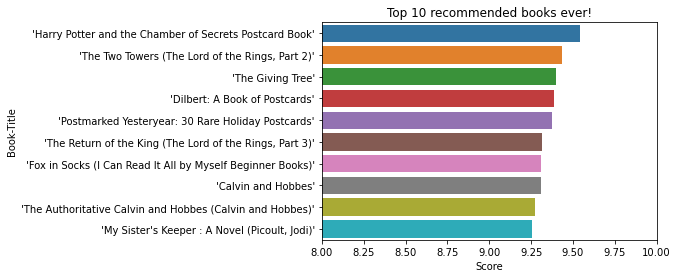

In [15]:
top_10= intersection_df.head(10)
sb.barplot(x = "Score", y = "Book-Title", data = top_10).set(title = "Top 10 recommended books ever!",xlim=(8,10))

So, according to the users of this dataset, wherever you are from, make sure to read these books first!

## By country: We will find the top rated books depending on the country of the user.

Next we find the top books by country. Is essentially the same as above however we implement it by adding an extra column and joining the isbn with the country in order to create the popularity demographic diagrams.

In [16]:
# Loading csv with preprocessed data cleaned
# cleaning the dataset according to our needs
df_cleaned = pd.read_csv('Preprocessed_data_cleaned.csv')

df_cleaned = df_cleaned[df_cleaned['country'] != ',']
df_cleaned = df_cleaned[df_cleaned['country'] != '\"n/a\""'] 

df_cleaned= df_cleaned.drop(columns=['user_id','Unnamed: 0','publisher','location','Language','Summary','year_of_publication','Category','city','state'])

df_cleaned['country']=df_cleaned['country'].str.split(',').str[-1]
df_cleaned['country']= df_cleaned['country'].replace(r' united kingdom',r'united kingdom')
df_cleaned['country']= df_cleaned['country'].replace(r'\"n/a\""',r'unknown')
df_cleaned= df_cleaned.sort_values(by=['country'],ascending=True)
df_cleaned=df_cleaned.reset_index(drop=True)
(df_cleaned['country']=='\"n/a\""').sum()
df_cleaned


,age,isbn,rating,book_title,book_author,country
0,33.0000,0140310657,10,The TV Kid (Puffin Books),Betsy Byars,australia
1,14.0000,0713100788,9,Discovering Greek Mythology (Woburn Educationa...,P. Kenneth Corsar,australia
2,33.0000,0140328262,10,The Paw Thing (Puffin Books),Paul Jennings,australia
3,13.0000,0340634448,5,The Cowboy Guide,Wayne Caba,australia
4,18.0000,0590454471,2,Picklemania (School Daze),Jerry Spinelli,australia
...,...,...,...,...,...,...
359445,21.0000,185326895X,8,Complete Works of William Shakespeare (Wordswo...,William Shakespeare,yugoslavia
359446,34.7439,0671000306,8,Shock Wave (Dirk Pitt Adventures (Paperback)),Clive Cussler,yugoslavia
359447,20.0000,0971880107,3,Wild Animus,Rich Shapero,yugoslavia
359448,55.0000,0671042858,7,The Girl Who Loved Tom Gordon,Stephen King,zambia


In [17]:
df_cleaned["isbn-country"] = df_cleaned["isbn"] + '-'+ df_cleaned["country"]

In [18]:
#counts the number of ratings in each country and puts them in to new dataframe

isbn_dict1=Counter(df_cleaned['isbn-country'])

df_cleaned_isbn_votecount = pd.DataFrame(list(isbn_dict1.items()), columns = ['isbn-country', 'Vote-Count'])

In [19]:
m= df_cleaned_isbn_votecount['Vote-Count'].quantile(0.9)
isbn_votecount_bycountry = df_cleaned_isbn_votecount[df_cleaned_isbn_votecount['Vote-Count'] >= m]
isbn_votecount_bycountry=isbn_votecount_bycountry.reset_index(drop=True)
print('The cut-off is {} and the cleaned dataframe contains {} rows.' .format(m,isbn_votecount_bycountry.shape[0]))

The cut-off is 3.0 and the cleaned dataframe contains 23448 rows.


In [20]:
#merging the dataframes
df_rating_bycountry= pd.merge(isbn_votecount_bycountry,df_cleaned, how='inner', on=['isbn-country'])

#Calculates the mean value of all the row with the same ISBN, hence the average rating which is put to the column 'Vote-Average'
df_rating_bycountry['Vote-Average-By-Country'] = df_rating_bycountry['rating'].groupby(df_rating_bycountry['isbn-country']).transform('mean')

#Deletes the duplicates and 'Book-Rating' column because we do not need them
df_rating_bycountry =df_rating_bycountry.drop_duplicates(subset='isbn-country', keep='first')
df_rating_bycountry =df_rating_bycountry.drop(['rating'], axis=1)

df_rating_bycountry.reset_index(drop=True)

,isbn-country,Vote-Count,age,isbn,book_title,book_author,country,Vote-Average-By-Country
0,0091842050-australia,7,13.0000,0091842050,The Blue Day Book: A Lesson in Cheering Yourse...,Bradley Trevor Greive,australia,9.000000
1,0684872153-australia,3,29.0000,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt,australia,6.333333
2,0452282152-australia,7,34.7439,0452282152,Girl with a Pearl Earring,Tracy Chevalier,australia,9.285714
3,0552998486-australia,9,17.0000,0552998486,Chocolat,Joanne Harris,australia,8.222222
4,0099740516-australia,5,39.0000,0099740516,Fall on Your Knees,Ann-Marie MacDonald,australia,7.200000
...,...,...,...,...,...,...,...,...
23443,0684865114-usa,7,34.7439,0684865114,The Restraint of Beasts,Magnus Mills,usa,7.428571
23444,0553577905-usa,3,19.0000,0553577905,Windhaven,George R. R. Martin,usa,7.000000
23445,0451402391-usa,6,34.7439,0451402391,The Search for the Green River Killer,Carlton Smith,usa,8.166667
23446,0060393823-usa,8,34.7439,0060393823,Lost,Gregory Maguire,usa,6.125000


In [21]:
C= df_rating_bycountry['Vote-Average-By-Country'].mean()
print('The value of C is: {}'.format(C))

The value of C is: 7.672355126591276


In [22]:
df_rating_bycountry['Score']=weighted_rating(df_rating_bycountry['Vote-Count'],df_rating_bycountry['Vote-Average-By-Country'], m=m, C=C)

df_rating_bycountry = df_rating_bycountry.sort_values('Score', ascending=False)
df_rating_bycountry

,isbn-country,Vote-Count,age,isbn,book_title,book_author,country,Vote-Average-By-Country,Score
126594,0439425220-usa,18,29.0000,0439425220,Harry Potter and the Chamber of Secrets Postca...,J. K. Rowling,usa,9.833333,9.524622
125663,0060256656-usa,17,37.0000,0060256656,The Giving Tree,Shel Silverstein,usa,9.823529,9.500853
64414,0836220889-usa,12,33.0000,0836220889,Calvin and Hobbes,Bill Watterson,usa,9.916667,9.467804
181025,0394800389-usa,12,28.0000,0394800389,Fox in Socks (I Can Read It All by Myself Begi...,Dr. Seuss,usa,9.833333,9.401138
86284,0439139597-usa,118,34.7439,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,usa,9.415254,9.372042
...,...,...,...,...,...,...,...,...,...
589,0971880107-australia,57,30.0000,0971880107,Wild Animus,Rich Shapero,australia,4.385965,4.550284
25660,1880985055-usa,5,34.7439,1880985055,Black Coffee Blues,Rollins,usa,2.600000,4.502133
96917,0971880107-usa,296,53.0000,0971880107,Wild Animus,Rich Shapero,usa,4.347973,4.381328
11871,0971880107-canada,53,34.7439,0971880107,Wild Animus,Rich Shapero,canada,4.188679,4.375305


In [23]:
# List of all the available countries
country_array= df_rating_bycountry["country"].drop_duplicates()
country_array= country_array.reset_index(drop=True)
country_list= list(country_array)
country_list

['usa',
 'united kingdom',
 'canada',
 'germany',
 'spain',
 'france',
 'malaysia',
 'philippines',
 'australia',
 'italy',
 'switzerland',
 'romania',
 'portugal',
 'iran',
 'finland',
 'new zealand',
 'netherlands',
 'austria',
 'brazil',
 'indonesia',
 'india',
 'poland',
 'ireland']

In [24]:
def suggest_top_10_books_by_country(country_from_user):
    if country_from_user in country_list:
        choose_country_df = df_rating_bycountry[df_rating_bycountry["country"] == country_from_user]
        choose_country_df =choose_country_df.sort_values('Score', ascending=False)
        top_10= choose_country_df.head(10)
        sb.barplot(x = "Score", y = "book_title", data = top_10).set(title = f"Top 10 recommended books in {country_from_user}", xlim=(7,10))
       
    else:
        print(f'Country not in the list, please choose one of the following:\n{country_array}')
        country_from_user = input('Type a country:')
        suggest_top_10_books_by_country(country_from_user)
    return

## Things get interactive here. 
### Please to continue & test the following cell, uncomment the following two lines of code and follow the instructions below.
It has only been commented out so that you won't face any issue if you "Run all" the cells.
By running this code, you as a user have to type in a country from the country column above. Then as a demographic result you get the ten best books by the country you input. If the country doesn't exist in the list, we print you the list with the existing countries and as a user you are called to retype a country and get the results.

# !NOTE! 
The code below stops only when you type in an existing country. In case you want to make it stop running after inputing a non existing country, you have to do it manually.

In [25]:
# Uncomment the next two lines of code to test our input recommendation
#country_from_user = input('Type in a country:')
#suggest_top_10_books_by_country(country_from_user)

Below we visualise in the same graph for comparison reasons the number of votes of each book (Vote-Count) and the weighted score (Score) .

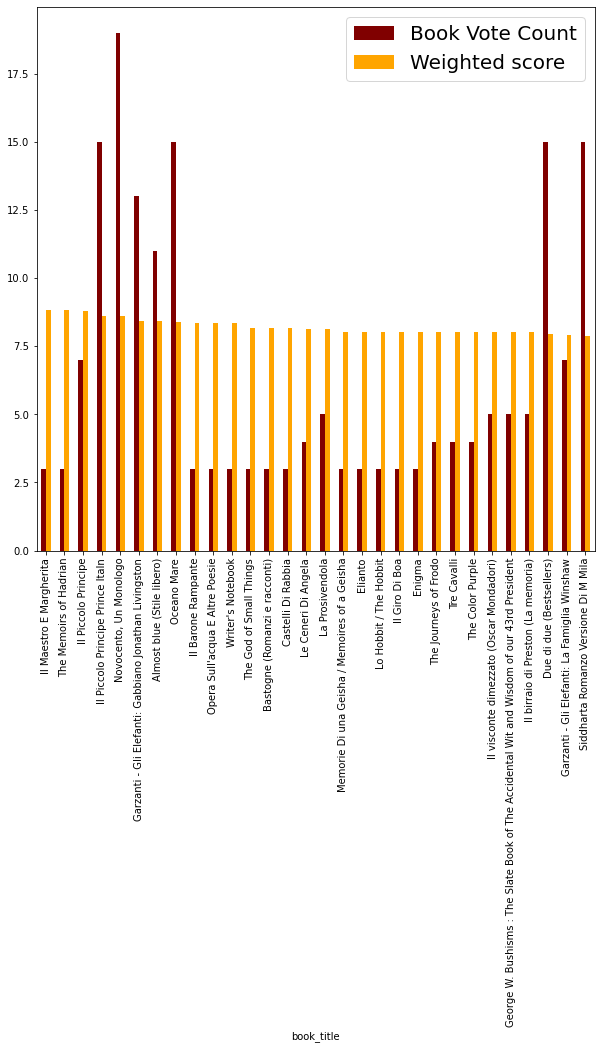

In [26]:
## Took Italy as an example.
italy_df = df_rating_bycountry[df_rating_bycountry["country"] == 'italy']
italy_df =italy_df.sort_values('Score', ascending=False)
top_30_italy= italy_df.head(30)
top_30_italy.plot.bar(x='book_title', y=['Vote-Count','Score'], color=['maroon','orange'],figsize=(10,10))
plt.legend(['Book Vote Count', 'Weighted score'], fontsize = 20)

The above graph approves that the books with the higher weighted score are not definitelly the ones with most of the votes. Vote counts varies between the top 30 books which means that no matter how many people have voted a book, it doesn't have to be highly ranked or recommended.

------------------------------------------------------------------------
# Content Filtering



### Data cleaning for Content based filtering

In [27]:
df = pd.read_csv('Preprocessed_data_cleaned.csv')
df = df[df['Language'] == 'en']
df=df.drop(columns=['Unnamed: 0', 'user_id','age','rating','year_of_publication','city','Language','state','country','location'])
## Clearing out the books and summaries that appear more than once in the dataframe
df =df.drop_duplicates(subset='isbn', keep='first')
df =df.drop_duplicates(subset='Summary', keep='first')
df['Summary'] = df['Summary'].fillna('')
df=df.reset_index(drop=True)
df
df.to_csv('Preprocessed_data_cleaned_for_content.csv', index=False)

### Summary based Recommender
Following the Content based recommendation approach, we computed the similarity scores of the books based on their summaries. Firstly we cleaned the dataset, this time removing all the languages except for english. This leaves us with enough data to demonstrate this type of filtering (76K books).

In [28]:
df= pd.read_csv('Preprocessed_data_cleaned_for_content.csv')
df=df.drop(columns=['book_author','Category','publisher'])

In [29]:
stop_words = set(stopwords.words('english'))
## takes str as input and cleans it of punctuation etc
def cleaner(aString):
    output = aString.lower()
    remove_punctuation=re.sub(r'[^\w\s]', '',  output)
    remove_back=re.sub(r'[0-9]',"",remove_punctuation) 
    remove_back=re.sub(r'[\n]'," ",remove_back) 
    text_tokens = word_tokenize(remove_back)
    str_no_stopw = [word for word in text_tokens if not word in stop_words]
    summary= (" ").join(str_no_stopw)
    return summary

In [30]:
# cleans the summaries of the books
df['Summary']=list(map(lambda x: cleaner(x),df['Summary']))

In [31]:
# Remove str reference
del str

We used the **Jaccard similarity** as an indicator of the similarity between the books’ summaries.

In [32]:
def Jaccard_Similarity(str1, str2): 
    str1 = str(str1)
    str2 = str(str2)

    # List the unique words in a document
    set1 = set(str1.split()) 
    set2 = set(str2.split())
    
    # Finds intersection os strings
    intersection = set1.intersection(set2)

    # Finds union of words of strings
    union = set1.union(set2)
        
    # Calculate Jaccard score  add reference Mining of Massive Datasets Book page 74 Chapter 3
    return float(len(intersection)) / len(union)

So, now we can create a function that calculates the similarity score for a book that takes as an input. In this function we get the index of a book and calculate the jackard similarity of all books with the chosen book and then we sort the books according to the similarity scores.

In [33]:
def get_recommendations(title, column):
    
    # Get the index of the book that matches the title
    idx = df[df['book_title']==title].index.values[0]

    # calculate the jaccard similarity of all books with that book
    Jaccard_score = list(map(lambda x: Jaccard_Similarity(x,df[column][idx]),df[column]))
    
    Jaccard_score_df = pd.DataFrame(Jaccard_score,columns =['Similarity_Score'])
    
    Jaccard_score_df = pd.merge(Jaccard_score_df, df, left_index=True, right_index=True)
    
    # Sort the books based on the similarity scores
    Jaccard_score_df = Jaccard_score_df.sort_values('Similarity_Score', ascending=False)
    
    # Get the scores of the 10 most similar books
    Jaccard_score_df = Jaccard_score_df[1:11]
    Jaccard_score_df = pd.DataFrame(Jaccard_score_df)
    Jaccard_score_df= Jaccard_score_df.reset_index(drop= True)

    # Return the top 10 most similar books
    return Jaccard_score_df

Let's take as an example the Book "Decision in Normandy".

,Similarity_Score,isbn,book_title,Summary
0,0.166667,1853673110,War on the Eastern Front: The German Soldier i...,first time paperback lucas details experiences...
1,0.125000,0060554886,The Illustrator in America : 1860-2000,first published revised third edition offered ...
2,0.120000,0140235426,Six Armies in Normandy: From D-Day to the Libe...,recreates military accomplishments delineates ...
3,0.115385,0864923732,"Saint John Fortifications, 1630-1956 (New Brun...",saint john fortifications first volume new bru...
4,0.115385,0385126514,For Her Own Good : 150 Years of the Experts' A...,provocative new perspective female history his...
5,0.114286,0590021117,Little House On the Prairie,first time history little house books new edit...
6,0.114286,0520201663,The Collected Poems of Frank O'Hara,available first time paperback collected poems...
7,0.114286,0060581859,The Long Winter (Little House),first time history little house books new edit...
8,0.114286,0590300946,Long Winter,first time history little house books new edit...
9,0.111111,0226718530,Readings in Russian Civilization: Russian Befo...,first volume undergone least change new items ...


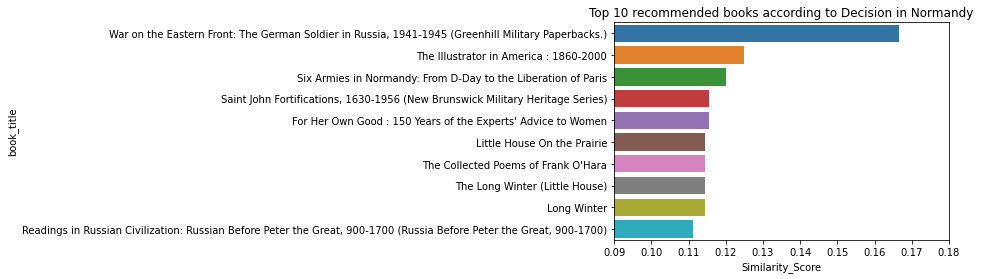

In [34]:
Jaccard_recommendation_df = get_recommendations("Decision in Normandy", "Summary")
sb.barplot(x = "Similarity_Score", y = "book_title", data = Jaccard_recommendation_df).set(title = "Top 10 recommended books according to Decision in Normandy", xlim=(0.09,0.18))
Jaccard_recommendation_df

In [35]:
def interactive_content_recommendation(book_title_from_user, column):
    if book_title_from_user in list(df['book_title']):
        Jaccard_recommendation_df = get_recommendations(book_title_from_user, column)
        sb.barplot(x = "Similarity_Score", y = "book_title", data = Jaccard_recommendation_df).set(title = f"Top 10 recommended books according to {book_title_from_user}")
       
    else:
        pd.options.display.max_colwidth = 100
        print(f'Book not in the list, please choose- copy & paste- one of the following -10 random examples-:\n{df["book_title"].sample(n=10)}')
        book_title_from_user = input('Type a book title:')
        interactive_content_recommendation(book_title_from_user, column)
    return

## Things get interactive here. 
### Please to continue & test the following cell, uncomment the following two lines of code and follow the instructions below.
It has only been commented out so that you won't face any issue if you "Run all" the cells.
By running this code, you as a user have to type in a book title. Then as a content based on the summary result you get the ten best books by the book title you input. If the book title doesn't exist in the list, we print you 10 random books from our dataframe and as a user you are called to copy-paste a book title and get the results.

# !NOTE! 
If you start running the code of the cell below, it is going to wait for you an input. It stops running only when you type in an existing book title. In case you want to make it stop running after inputing a non existing book title, for any reason, you have to do it manually.

Below we provide you with the output as an example if the user types as book title first a book title that doesn't exist and then the book title "Psychic Protection"

In [36]:
# Uncomment the next 2 lines to test our user input recommender
#title_from_user = input()
#interactive_content_recommendation(title_from_user, "Summary")

### Variable based Recommender 
In this section, we create a mix or "soup" of each book's "features" (Title, Author, Publisher and Category) and we recommend a top 10 to a user based on this data analysis.
We tryed out several combinations to verify which "soup" works best according to the content based recommendation for the user.
### 1. Title, Author, Publisher and Category

In [37]:
df = pd.read_csv('Preprocessed_data_cleaned_for_content.csv')
df=df.drop(columns=['Summary'])
df['book_title_cleaned']=list(map(lambda x: cleaner(x),df['book_title']))

In [38]:
# Data analysis
features = ['book_title_cleaned', 'book_author', 'publisher', 'Category']
analysis_filename = 'data_analysis.txt'

for current_feature in features:
    unique_values = df[current_feature].unique().tolist()

    with open(f"{analysis_filename}_{current_feature}", 'w', encoding="utf-8") as f:
        for v in unique_values:
            f.write("%s\n" % v)

# See how common each category is
print(df[features[3]].value_counts())

['Fiction']                                               30332
['Juvenile Fiction']                                       5296
['Biography & Autobiography']                              3090
['History']                                                1782
['Religion']                                               1715
                                                          ...  
['Afrikaners']                                                1
['Fugitives from justice']                                    1
['Midlife crisis']                                            1
['Maigret, Jules (Fictitious character)']                     1
['Authors, Canadian (English) 20th century Biography']        1
Name: Category, Length: 3745, dtype: int64


In [39]:
# Clean 'category column'

features = ['book_title_cleaned', 'book_author', 'publisher', 'Category']

# Parse the stringified features into their corresponding python objects
df[features[3]] = df[features[3]].apply(literal_eval)

# Since each list contains only 1 element, replace the list by the element inside while dealing
# with the 9 values
def get_str_from_list(val):
    if val == 9:
        return "9"
    return val[0]

df[features[3]] = df[features[3]].apply(get_str_from_list)

# Current features head
df[features].head()

,book_title_cleaned,book_author,publisher,Category
0,clara callan,Richard Bruce Wright,HarperFlamingo Canada,Actresses
1,decision normandy,Carlo D'Este,HarperPerennial,1940-1949
2,flu story great influenza pandemic search viru...,Gina Bari Kolata,Farrar Straus Giroux,Medical
3,kitchen gods wife,Amy Tan,Putnam Pub Group,Fiction
4,worlds foremost military historians imagine might,Robert Cowley,Berkley Publishing Group,History


In [40]:
# Function to convert all strings to lower case and strip names of spaces
def lower_and_remove_spaces(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if author exists. If not, return empty string
        if isinstance(x, str):
            return x.replace(" ", "").lower()
        else:
            return ''

def lower(x):
    return x.lower()


# Apply clean_data function to selected features.
remove_spaces_features = ['book_author', 'publisher']

for feature in remove_spaces_features:
    df[feature] = df[feature].apply(lower_and_remove_spaces)

for feature in features:
    df[feature] = df[feature].apply(lower)

In [41]:
# Start recommender system

def create_soup(x):
    soup = ""
    for feature in features:
        soup += x[feature] + ' '
    return soup
df['soup'] = df.apply(create_soup, axis=1)

print(df['soup'].head())

0    clara callan richardbrucewright harperflamingo...
1    decision normandy carlod'este harperperennial ...
2    flu story great influenza pandemic search viru...
3     kitchen gods wife amytan putnampubgroup fiction 
4    worlds foremost military historians imagine mi...
Name: soup, dtype: object


In [42]:
jaccard_score_df = get_recommendations("Decision in Normandy", "soup")
jaccard_score_df['book_title']

0                                     Emerald Decision
1                                   Flavor of Normandy
2                                    Decision at Doona
3                     The Decision (Animorphs, No. 18)
4                The Decision (Palisades Pure Romance)
5                The portable pediatrician for parents
6    Decision in Philadelphia: The Constitutional C...
7             Perfection of the Morning an Apprentices
8          Decision at Thunder Rift (Battletech, No 6)
9            Currahee!:  A Screaming Eagle at Normandy
Name: book_title, dtype: object

[Text(0.5, 1.0, 'Top 10 recommended books according to Decision in Normandy')]

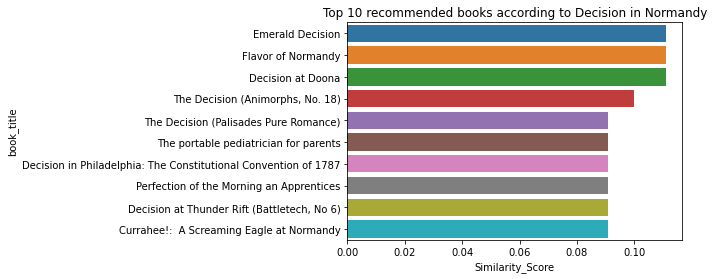

In [43]:
sb.barplot(x = "Similarity_Score", y = "book_title", data = jaccard_score_df).set(title = "Top 10 recommended books according to Decision in Normandy")


### 2. Author, Publisher, Category
We create a new "soup" excluding the book title to compare the results

[Text(0.5, 1.0, 'Top 10 recommended books according to Decision in Normandy')]

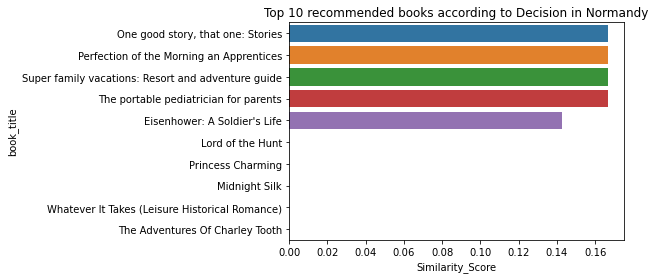

In [44]:
features = ['book_author', 'publisher', 'Category']
df['soup'] = df.apply(create_soup, axis=1)
# Show what the current soup for the first book look like
jaccard_score_df = get_recommendations("Decision in Normandy", "soup")
jaccard_score_df
sb.barplot(x = "Similarity_Score", y = "book_title", data = jaccard_score_df).set(title = "Top 10 recommended books according to Decision in Normandy")


### 3.Summary, Author, Publisher, Category


In [48]:
# Data cleaning
df = pd.read_csv('Preprocessed_data_cleaned_for_content.csv')
features = ['Summary', 'book_author', 'publisher', 'Category']

# Parse the stringified features into their corresponding python objects
df[features[3]] = df[features[3]].apply(literal_eval)
df[features[3]] = df[features[3]].apply(get_str_from_list)
# Apply clean_data function to selected features.
remove_spaces_features = ['book_author', 'publisher']

for feature in remove_spaces_features:
    df[feature] = df[feature].apply(lower_and_remove_spaces)

for feature in features:
    df[feature] = df[feature].apply(lower)

df['Summary']=list(map(lambda x: cleaner(x),df['Summary']))
df['soup'] = df.apply(create_soup, axis=1)

In [49]:
# this is what the soup looks like after cleaning and applying the changes

print(df['soup'].head())

0    small town canada clara callan reluctantly tak...
1    first time paperback outstanding military hist...
2    describes great flu epidemic outbreak killed f...
3    chinese immigrant convinced dying threatens ce...
4    essays respected military historians including...
Name: soup, dtype: object


[Text(0.5, 1.0, 'Top 10 recommended books according to Decision in Normandy')]

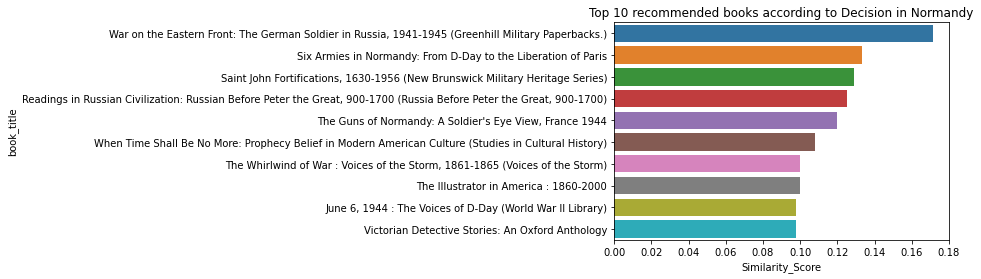

In [50]:
jaccard_score_df = get_recommendations("Decision in Normandy", "soup")
sb.barplot(x = "Similarity_Score", y = "book_title", data = jaccard_score_df).set(title = "Top 10 recommended books according to Decision in Normandy")